In [7]:
camc = '/Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/spinup_pd_maxcores_5deg.cam2.h0.????-??.nc'
camg = '/Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/mres_b.e10.B2000_CAM5.5deg.001.cam2.h0.????-??.nc'

In [31]:
![ -f test.nc ] && rm test.nc
!python ../jobs/windshear/snellius/windshear.py /Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/spinup_pd_maxcores_5deg.cam2.h0.????-??.nc test.nc

2024-07-09 12:10:58,199 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:57174
Traceback (most recent call last):
  File "/Users/jasperdejong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jasperdejong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 54] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/jasperdejong/opt/anaconda3/envs/py311/lib/python3.11/site-packages/distributed/worker.py", line 2035, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jasperdejon

In [4]:
import os
import sys
import time
import argparse
import logging
#print(f'Python version: {sys.version}')
#print(f'Path: {sys.path}')

from numba import guvectorize
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
#xr.show_versions()

PLEVS = (250, 850)  # pressure levels (hPa) for shear calculation

# variable names (change values if needed)
# VARS = {'U':'U','V':'V','P':'P','gw':'gw', 'time_bnds':'time_bnds','lsm':'lsm'} # pressure levels
VARS = {'U':'U','V':'V','hyam':'hyam', 'hybm':'hybm','P0':'P0','PS':'PS',
        'gw':'gw', 'time_bnds':'time_bnds','lsm':'LANDFRAC'} # hybrid model levels

LABEL = 'upper' # ['upper','lower'], level where VSHEAR is defined
VDIM = 'lev'  # vertical dimension (e.g. 'lev','plev','z','hybrid')
CHUNKS = {'time':1,'ncol':'auto', VDIM:-1} # array chunk size for parallel computation
NEWPRES = xr.DataArray(
    data=100*np.array(sorted(PLEVS), dtype='float64'),
    dims='plev',
    name='p',
    attrs={'standard_name':'air_pressure',
           'long_name':'air pressure',
           'units':'Pa'}
)


@guvectorize([
    "(float64[:], float64[:], float64[:], float64[:])",
    "(float32[:], float32[:], float64[:], float32[:])"
], " (n), (n), (m) -> (m)", nopython=True, cache=True)
def logpressure_interp1d_gu(f, p, pi, out):
    """interpolate field f(p) to pi in ln(p) coordinates"""
    i, imax, p0, f0 = 0, len(pi), p[0], f[0]
    while pi[i]<p0 and i < imax:
        out[i] = np.nan      
        i = i + 1 
    for p1,f1 in zip(p[1:], f[1:]):
        while pi[i] <= p1 and i < imax:
            out[i] = (f1-f0)/np.log(p1/p0)*np.log(pi[i]/p0)+f0
            i = i + 1
        p0, f0 = p1, f1
    while i < imax:
        out[i] = np.nan
        i = i + 1


def xr_interpolate_pressure(ds):
    """wrapper for logpressure_interp1d_gu"""
    # calculate pressure if needed and interpolate
    if 'P' not in VARS:
        logging.info(f"calculating 'P' from hybrid parameters")
        pres = ds[VARS['hyam']] * ds[VARS['P0']] + ds[VARS['hybm']] * ds[VARS['PS']]
    else:
        pres = ds[VARS['P']]
    ds = ds.assign_coords({NEWPRES.name:NEWPRES})
    logging.info(f"new coordinate: {ds[NEWPRES.name].coords}")
    logging.info("starting interpolation...")
    vdimvars = [v for v in ds.data_vars if hasattr(ds[v], VDIM)]
    if len(vdimvars) == 1:
        vdimvars = vdimvars[0]
    ds[vdimvars] = xr.apply_ufunc(
        logpressure_interp1d_gu,  ds[vdimvars], pres, NEWPRES,
        input_core_dims=[[VDIM], [VDIM], [*NEWPRES.dims]], 
        output_core_dims=[[*NEWPRES.dims]], 
        exclude_dims=set((VDIM,)),
        dask="parallelized",
        keep_attrs=True,
    ).transpose(*NEWPRES.dims,...)
    return ds
    

def check_globals(ds):
    """Check global variables defined in this file
    
    When faulty, quits program with helpful error messages
    """
    fatal = False
    if VDIM not in ds:
        logging.error(f"vertical dimension {VDIM} not in dataset")
        fatal = True
    else:
        logging.info(f"vertical dimension: {VDIM}")
    if any(p > 1100 for p in PLEVS):
        logging.error(f"PLEVS {PLEVS} should be in hPa")
        fatal = True
    else:
        logging.info(f"new pressure levels: {PLEVS} hPa")
    if ('P' not in VARS):
        missing_terms = [VARS[t] for t in ['hyam','hybm','P0','PS'] if VARS[t] not in ds]
        if any(missing_terms):
            logging.error(f"{missing_terms} not in dataset")
            fatal = True
        else:
            for v in ['PS','P0']:
                var = ds[VARS[v]]
                if not hasattr(var, 'units'):
                    logging.warning(f"assuming {var.name} has units 'Pa'")
                elif var.units in ['Pa','pa']:
                    logging.info(f"{var.name} units: {var.units}")
                else:
                    logging.error(f"{var.name} units: {var.units}, expected Pa")
                    fatal = True
            logging.info(f"using {[VARS[v] for v in ['hyam','hybm','P0','PS']]} to calculate pressure")
    else:
        logging.info(f"using pressure '{VARS['P']}'")
    if fatal:
        logging.critical(f"fatal errors occurred for dataset:\n{ds}")
        logging.critical(f"resolve errors first, aborting...")
        sys.exit(1)
    return


def main():
    time0 = time.perf_counter()  # start timer

    # # parse command line arguments
    # parser = argparse.ArgumentParser()
    # parser.add_argument('files', nargs='+', help='input file(s)')
    # parser.add_argument('outfile', help='output file')
    # parser.add_argument('-f', help='used by jupyter')
    # parser.add_argument('-v', '--verbose', help='modify output verbosity', 
    #                     action='store_true')
    # args = parser.parse_args()

    # # set up logger 
    # logging.basicConfig(
    #     level=logging.INFO if args.verbose else logging.WARNING,
    #     format="%(asctime)s %(levelname)s: %(message)s",
    #     datefmt="%d-%m-%Y %H:%M:%S"
    # )
    # logging.info(
    #     f"read path: {os.path.dirname(os.path.abspath(args.files[0]))}:"
    #     "\ninput file(s):"
    #     f"\n{os.linesep.join([os.path.basename(f) for f in args.files])}"
    # )
    
    # wind shear calculation
    time1 = time.perf_counter()  # start timer
    levstr = f'{max(PLEVS)}-{min(PLEVS)} hPa'
    # logging.info(f"opening [{args.files[0]} - {args.files[-1]}] with chunks {CHUNKS}")
    with xr.open_mfdataset(camc, data_vars="minimal", coords="minimal", 
        join="exact", compat="override", chunks=CHUNKS) as ds:
        time2 = time.perf_counter()
        # logging.info(f"...succes! opening took {time2-time1:.2f} seconds")
        ds = ds[list(VARS.values())]
        check_globals(ds)
        hasplev = NEWPRES.dims[0] in ds.dims
        if (not hasplev) or (hasplev and (not (ds[NEWPRES.dims[0]] == NEWPRES).all())):
            ds = xr_interpolate_pressure(ds)
        USHEAR = ds[VARS['U']].diff(NEWPRES.dims[0], label=LABEL).squeeze()
        VSHEAR = ds[VARS['V']].diff(NEWPRES.dims[0], label=LABEL).squeeze()
        ds['VWS'] = np.sqrt(USHEAR**2 + VSHEAR**2)
        ds.VWS.attrs.update({
            'long_name':'vertical wind shear '+levstr,
            'standard_name':'wind_speed_shear',
            'units':ds[VARS['U']].units,
        })
        ds[['VWS',VARS['gw'],VARS['time_bnds'],VARS['lsm']]].to_netcdf('test.nc')
        time3 = time.perf_counter()
        # logging.info(f"processed all data in {time3-time1:.2f} seconds")

In [4]:
%%time
main()

CPU times: user 5.47 s, sys: 504 ms, total: 5.97 s
Wall time: 5.96 s


In [25]:
ds = xr.open_dataset('test.nc')

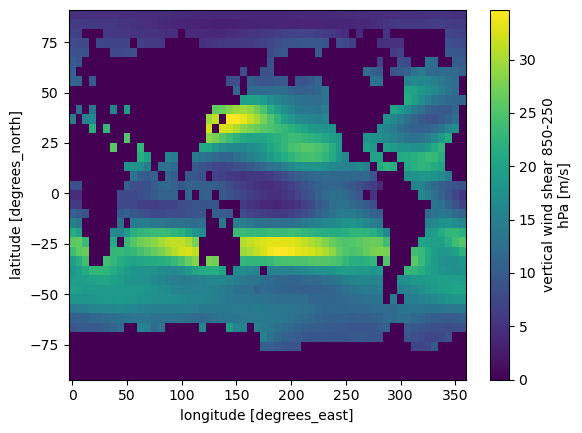

In [26]:
filledVWS = ds.VWS.copy()
filledVWS.data[ds.LANDFRAC>0] = 0
(filledVWS).mean('time').plot()

In [27]:
ds.VWS.weighted(ds.gw).mean(('lat','lon')).values

array([17.01473168, 16.08787384, 16.5594063 , 16.05265361, 15.34998002,
       15.18193676, 15.15746351, 15.70697657, 15.08829798, 14.93842896,
       15.50816053, 15.8616762 , 16.82060211, 16.44960549, 15.83352564,
       15.69123303, 14.78173351, 14.54914266, 15.52210192, 15.21290275,
       14.81622729, 14.86517483, 15.69912501, 16.82675398])

In [28]:
ds.attrs

{'Conventions': 'CF-1.0',
 'source': 'CAM',
 'case': 'spinup_pd_maxcores_f05_t12',
 'title': 'UNSET',
 'logname': 'klipdccp',
 'host': 'tcn1633.bullx',
 'Version': '$Name$',
 'revision_Id': '$Id$',
 'initial_file': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/inputdata/atm/cam/inic/fv/cami-mam3_0000-01-01_0.47x0.63_L30_c100929.nc',
 'topography_file': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/inputdata/atm/cam/topo/USGS_gtopo30_0.47x0.63_remap_c061106.nc',
 'history': 'python windshear.py [/Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/spinup_pd_maxcores_5deg.cam2.h0.0194-01.nc - /Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/spinup_pd_maxcores_5deg.cam2.h0.0297-12.nc] test.nc'}

In [29]:
ds.close()